In [1]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
TARGET_NAMES = ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'brandine_spuckler','carl_carlson',
                  'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler','comic_book_guy', 'disco_stu', 'dolph_starbeam','duff_man','edna_krabappel',
                  'fat_tony', 'gary_chalmers','gil', 'groundskeeper_willie', 'homer_simpson','jimbo_jones', 'kearney_zzyzwicz','kent_brockman', 'krusty_the_clown', 'lenny_leonard',
                  'lionel_hutz', 'lisa_simpson', 'lunchlady_doris','maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby','milhouse_van_houten',
                  'miss_hoover', 'moe_szyslak', 'ned_flanders','nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner',
                  'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum','selma_bouvier', 'sideshow_bob', 'sideshow_mel',
                  'snake_jailbird','troy_mcclure', 'waylon_smithers']
CLASSES = len(TARGET_NAMES)
image_size_scaling = (128,128)

# TRAIN_ROOT_PATH = "/content/drive/MyDrive/deepLearning/Project/data/simpsons_dataset/simpsons_dataset"
# TEST_ROOT_PATH = "/content/drive/MyDrive/deepLearning/Project/data/simpsons_testdataset/simpsons_testdataset"
TRAIN_ROOT_PATH = "/kaggle/input/the-simpsons-dataset-compilation-49-characters/simpsons_dataset/simpsons_dataset"
TEST_ROOT_PATH = "/kaggle/input/the-simpsons-dataset-compilation-49-characters/simpsons_testdataset/simpsons_testdataset"
epochs = 50
batch_size = 128
num_of_train_samples = 29894
num_of_test_samples = 4555

Num GPUs Available:  2


In [2]:
#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True, # randomly flip images
                                   fill_mode='nearest')

#the train data generator ( retrieves the data and scales it, also feeds using the batches into the model )
train_generator=train_datagen.flow_from_directory(TRAIN_ROOT_PATH,
                                                 target_size=image_size_scaling,
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)
#the validation generator for testing the model
test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = test_datagen.flow_from_directory(TEST_ROOT_PATH,
                                                        target_size=image_size_scaling,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True)

Found 29895 images belonging to 49 classes.
Found 4632 images belonging to 49 classes.


## Modelo ResNet

In [3]:
# Crear el modelo ResNet
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Descongelar más capas de la base
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Redefinir la arquitectura personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(CLASSES, activation='softmax')(x)

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
import tensorflow as tf
from keras.callbacks import Callback, ModelCheckpoint
# Para verificar el modelo tanto el accuracy como el val_loss
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor1='val_accuracy', monitor2='val_loss', mode1='max', mode2='min', verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor1 = monitor1
        self.monitor2 = monitor2
        self.mode1 = mode1
        self.mode2 = mode2
        self.verbose = verbose
        self.best_val_accuracy = -float('inf') if mode1 == 'max' else float('inf')
        self.best_val_loss = float('inf') if mode2 == 'min' else -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get(self.monitor1)
        current_val_loss = logs.get(self.monitor2)

        # Check if we should save the model based on val_accuracy
        if self.mode1 == 'max':
            if current_val_accuracy > self.best_val_accuracy:
                self.best_val_accuracy = current_val_accuracy
                save_model = True
            else:
                save_model = False
        elif self.mode1 == 'min':
            if current_val_accuracy < self.best_val_accuracy:
                self.best_val_accuracy = current_val_accuracy
                save_model = True
            else:
                save_model = False

        # Check if we should save the model based on val_loss
        if self.mode2 == 'min':
            if current_val_loss < self.best_val_loss:
                self.best_val_loss = current_val_loss
                save_model = True
            else:
                save_model = False
        elif self.mode2 == 'max':
            if current_val_loss > self.best_val_loss:
                self.best_val_loss = current_val_loss
                save_model = True
            else:
                save_model = False

        # Save the model if either condition is met
        if save_model:
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: saving model with val_accuracy: {current_val_accuracy} and val_loss: {current_val_loss}")
            self.model.save_weights(self.filepath, overwrite=True)

In [5]:
# Verificar el número de clases detectadas por el generador
print("Clases detectadas por el generador de entrenamiento:", train_generator.num_classes)
print("Clases detectadas por el generador de validación:", validation_generator.num_classes)

# Asegúrate de que el número de clases coincida
assert train_generator.num_classes == CLASSES, "El número de clases del generador de entrenamiento no coincide con CLASSES"
assert validation_generator.num_classes == CLASSES, "El número de clases del generador de validación no coincide con CLASSES"

# Configura el callback personalizado para guardar el mejor modelo
checkpoint = CustomModelCheckpoint(filepath='model.weights.h5', monitor1='val_accuracy', monitor2='val_loss', mode1='max', mode2='min', verbose=1)

callbacks_list = [checkpoint]

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=num_of_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=num_of_test_samples // batch_size,
    callbacks=callbacks_list
)


Clases detectadas por el generador de entrenamiento: 49
Clases detectadas por el generador de validación: 49
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731339687.570685     113 service.cc:145] XLA service 0x7c94d4003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731339687.570735     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731339687.570739     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731339779.462163     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers a

 21/233 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.0403 - loss: 5.7453

I0000 00:00:1731339893.600266     114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_75', 40 bytes spill stores, 40 bytes spill loads



233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3775 - loss: 3.5080Epoch 1: saving model with val_accuracy: 0.02879464253783226 and val_loss: 5.9356584548950195
233/233 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.3784 - loss: 3.5032 - val_accuracy: 0.0288 - val_loss: 5.9357
Epoch 2/50
  1/233 ━━━━━━━━━━━━━━━━━━━━ 3:38 940ms/step - accuracy: 0.8125 - loss: 1.4361

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8125 - loss: 1.4361 - val_accuracy: 0.0197 - val_loss: 6.0395
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.8603 - loss: 1.2258Epoch 3: saving model with val_accuracy: 0.05669642984867096 and val_loss: 5.166472434997559
233/233 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.8603 - loss: 1.2255 - val_accuracy: 0.0567 - val_loss: 5.1665
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9219 - loss: 0.9631 - val_accuracy: 0.0395 - val_loss: 5.3699
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.9140 - loss: 0.9828Epoch 5: saving model with val_accuracy: 0.3433035612106323 and val_loss: 3.5400733947753906
233/233 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9140 - loss: 0.9827 - val_accuracy: 0.3433 - val_loss: 3.5401
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9766 - loss: 0.7462 - val_accuracy: 0.2895 - val_loss: 3.7467
Epoch 7/50
233/233 ━━━━━━━━━━━

In [8]:
#saving the model for further re use
model_json = model.to_json()
with open('modelk.json', 'w') as json_file:
    json_file.write(model_json)
model.save('modelresnet_weightsk.h5')

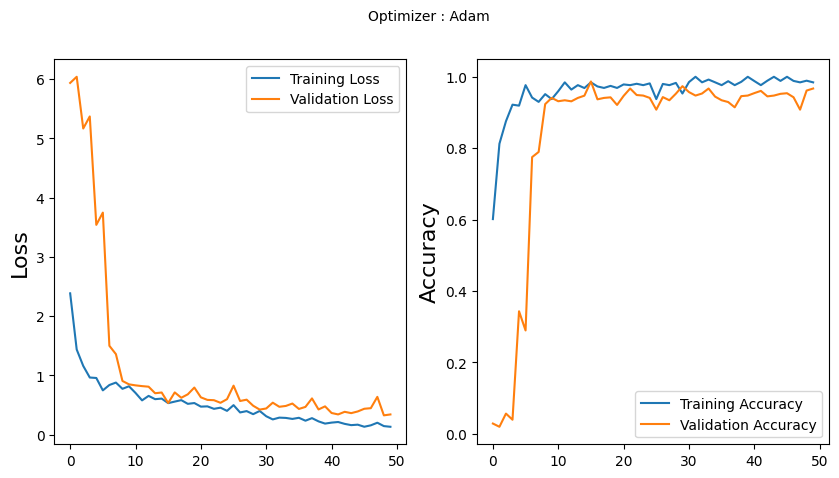

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()